In [1]:
import pandas as pd 
import numpy as np 
import pickle 
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt

In [2]:
from utils.tsplot import * 

### Load Data

In [3]:
df = pd.read_csv('PJM_Load_hourly.csv', header=None)

In [4]:
df.columns = ['datetime', 'demand']

In [5]:
df['diff_demand'] = np.log(df.demand).diff(1)

In [6]:
df.shape

(32896, 3)

### Visualising Data

(<matplotlib.axes._subplots.AxesSubplot at 0x7f1be22212e0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f1be19a7c70>)

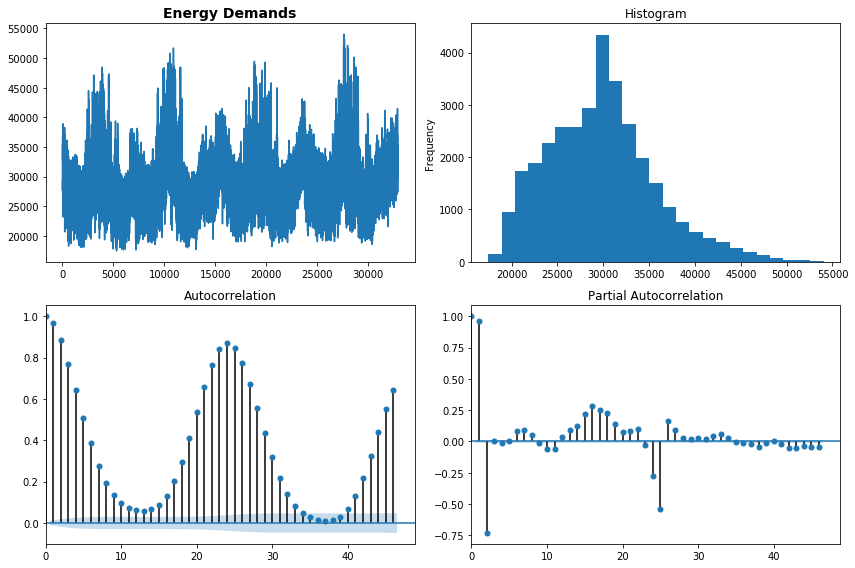

In [7]:
### Everything
tsplot(df.demand, 'Energy Demands')

(<matplotlib.axes._subplots.AxesSubplot at 0x7f1be1653eb0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f1be1812460>)

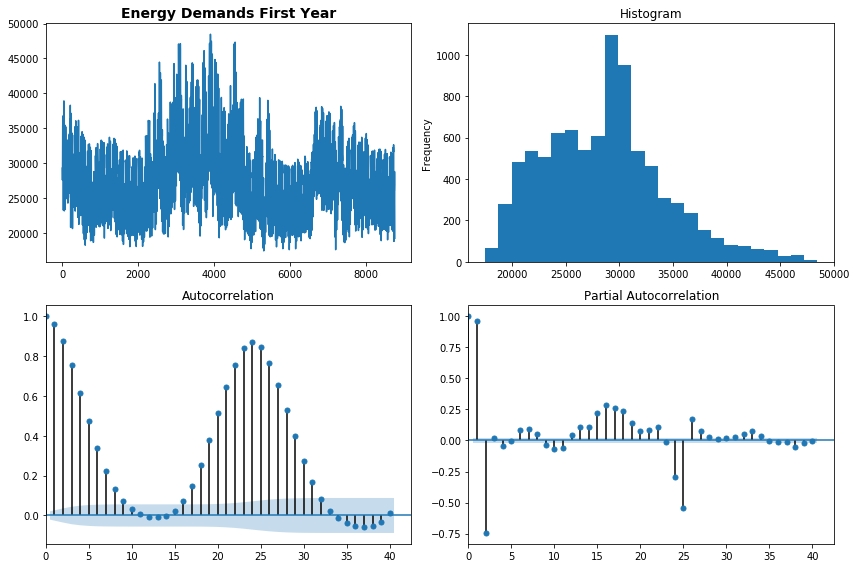

In [8]:
### First year 
tsplot(df[:24*365].demand, 'Energy Demands First Year')

(<matplotlib.axes._subplots.AxesSubplot at 0x7f1c0d350d90>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f1be005d580>)

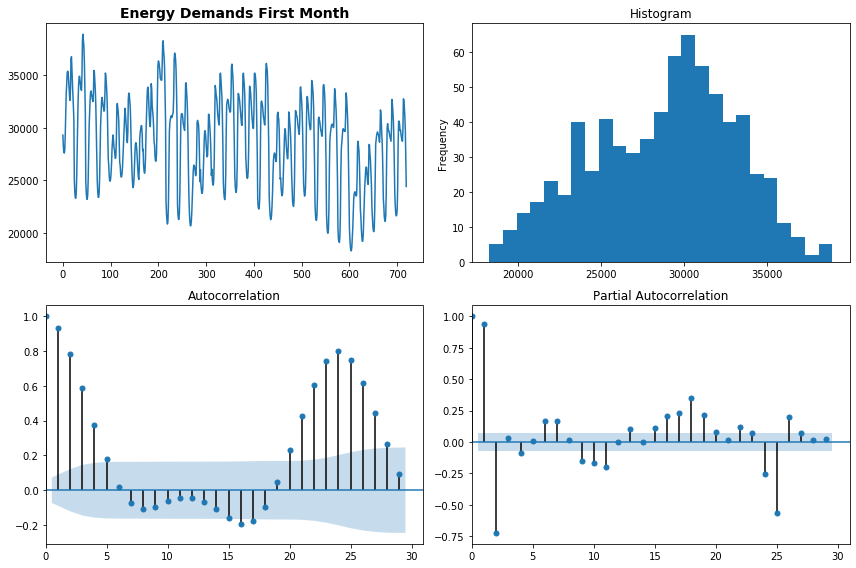

In [9]:
### First Month 
tsplot(df[:24*30].demand, 'Energy Demands First Month')

(<matplotlib.axes._subplots.AxesSubplot at 0x7f1bdb755910>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f1bdb6ef3a0>)

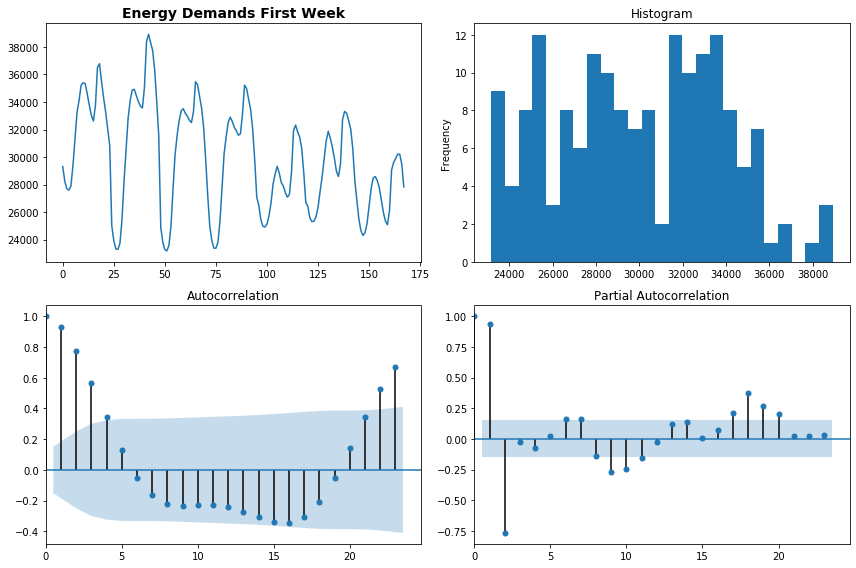

In [10]:
### First Week  
tsplot(df[:24*7].demand, 'Energy Demands First Week')

Seems like there exist: 
1. Slight increasing trend over the 3 years 
2. Monthly Cycle
3. Daily Cycle

(<matplotlib.axes._subplots.AxesSubplot at 0x7f1bdb5c4f70>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f1bdb4fd340>)

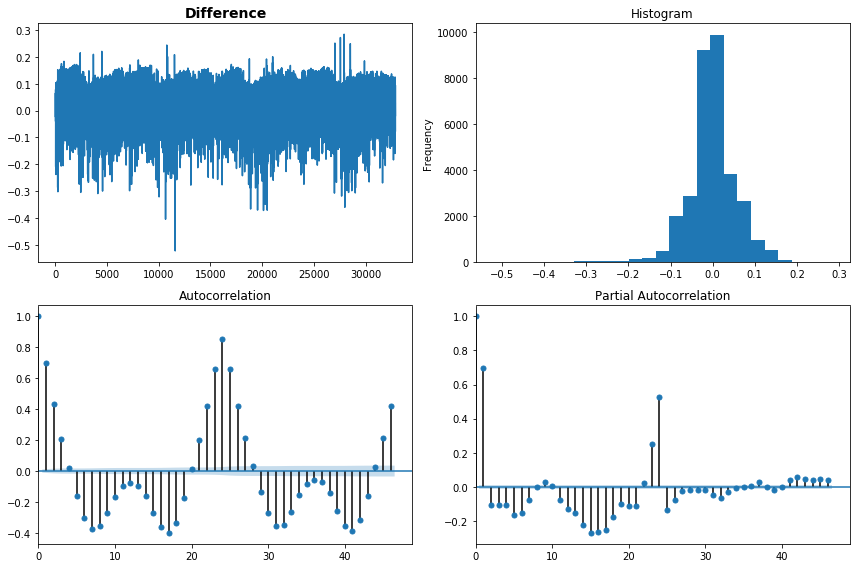

In [11]:
### Difference  
tsplot(df.diff_demand.dropna(), 'Difference')

The mean and variance seems to be somewhat constant, but there exists very prominent autocorrelation. 

### Extracting time features

In [12]:
df['datetime'] = pd.to_datetime(df['datetime'])
df['month'] = df['datetime'].dt.month 
df['day'] = df['datetime'].dt.day 
df['hour'] = df['datetime'].dt.hour
df['since_start'] = (df['datetime'] - df['datetime'][0]).astype('timedelta64[h]')

In [13]:
df = df.drop('datetime', axis = 1)

In [14]:
df = pd.concat([df, pd.get_dummies(df['month'], prefix='month')], axis = 1)
df = pd.concat([df, pd.get_dummies(df['day'], prefix='day')], axis = 1)
df = pd.concat([df, pd.get_dummies(df['hour'], prefix='hour')], axis = 1)

In [15]:
df = df.drop('month', axis = 1)
df = df.drop('day', axis = 1)
df = df.drop('hour', axis = 1)

### Standardizing 

In [16]:
demand_mean = df.mean()['demand']
demand_std = df.std()['demand']

In [17]:
print(demand_mean)
print(demand_std)

29766.427407587547
5849.76995358656


In [18]:
df = (df-df.mean())/df.std()
df = df.dropna()

In [19]:
df.shape

(32895, 70)

### Creating prediction windows

In [132]:
WINDOW_SIZE = 100 
LAG = 5

In [133]:
index_size = df.shape[0] - WINDOW_SIZE - LAG 
dim_size = 2 # demand and difference 

In [134]:
X = np.zeros((WINDOW_SIZE, index_size, dim_size)) #time, index, dim

In [139]:
for i in range(WINDOW_SIZE): 
    X[i,:,:] = df.iloc[:,:dim_size].values[i:index_size + i,:]

In [140]:
X = X.transpose((1,0,2))

In [141]:
X.shape

(32790, 100, 2)

In [149]:
X_static = df.iloc[WINDOW_SIZE + LAG:df.shape[0],2:].values # absolut time, 12 months in a year, 30/31 days in a month, 24 hours in a day

In [150]:
X_static.shape

(32790, 68)

In [151]:
Y = df.demand[WINDOW_SIZE + LAG:].values

In [152]:
Y.shape

(32790,)

### Split to Train, Val, and Test sets

In [165]:
TRAIN_TEST_SPLIT = .8 
TRAIN_VAL_SPLIT = .8

In [166]:
X_train_ = X[:int(X.shape[0] * TRAIN_TEST_SPLIT)]
X_static_train_ = X_static[:int(X.shape[0] * TRAIN_TEST_SPLIT)]
Y_train_ = Y[:int(X.shape[0] * TRAIN_TEST_SPLIT)]

In [167]:
X_test = X[int(X.shape[0] * TRAIN_TEST_SPLIT):]
X_static_test = X_static[int(X.shape[0] * TRAIN_TEST_SPLIT):]
Y_test = Y[int(Y.shape[0] * TRAIN_TEST_SPLIT):]

In [168]:
X_train = X_train_[:int(X_train_.shape[0] * TRAIN_VAL_SPLIT)]
X_static_train = X_static_train_[:int(X_train_.shape[0] * TRAIN_VAL_SPLIT)]
Y_train = Y_train_[:int(X_train_.shape[0] * TRAIN_VAL_SPLIT)]
X_val = X_train_[int(X_train_.shape[0] * TRAIN_VAL_SPLIT):]
X_static_val = X_static_train_[int(X_train_.shape[0] * TRAIN_VAL_SPLIT):]
Y_val = Y_train_[int(X_train_.shape[0] * TRAIN_VAL_SPLIT):]

In [216]:
#test_idx = np.random.choice(range(X_train_.shape[0]), int(X_train_.shape[0] * TRAIN_VAL_SPLIT), replace=False)  
#assert np.unique(test_idx).shape[0] == test_idx.shape[0]
#X_train = X_train_[test_idx]
#Y_train = Y_train_[test_idx]
#X_val = X_train_[np.delete(range(X_train_.shape[0]), test_idx)]
#Y_val = Y_train_[np.delete(range(X_train_.shape[0]), test_idx)]

In [171]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(20985, 100, 2)
(5247, 100, 2)
(6558, 100, 2)


In [173]:
print(X_static_train.shape)
print(X_static_val.shape)
print(X_static_test.shape)

(20985, 68)
(5247, 68)
(6558, 68)


In [174]:
print(Y_train.shape)
print(Y_val.shape)
print(Y_test.shape)

(20985,)
(5247,)
(6558,)


### Save clean data 

In [175]:
outfile = open('clean_data.pkl', 'wb')
pickle.dump(( (X_train, X_static_train, Y_train), (X_val,X_static_val, Y_val), (X_test, X_static_test, Y_test)), 
            outfile)
outfile.close()